In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import scipy.signal

In [2]:
img_paths = ["data/c02_s07.png", "data/c06_s01.png", "data/c15_s02.png",
            "data/c10_s07.png", "data/c10_s06.png", "data/c15_s06.png"]

imgs = [cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB) for path in img_paths]

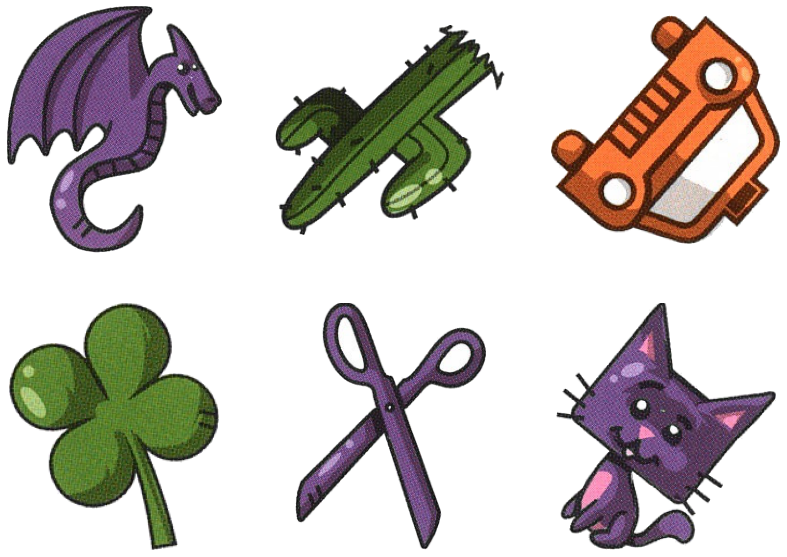

In [3]:
fig, ax_arr = plt.subplots(figsize=(14,10),nrows=2, ncols=3)

for img, ax in zip(imgs, np.nditer(ax_arr, flags=["refs_ok"])):
    ax.item().imshow(img)
    ax.item().set_axis_off()

In [4]:
imgs_gray = [cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) for img in imgs]

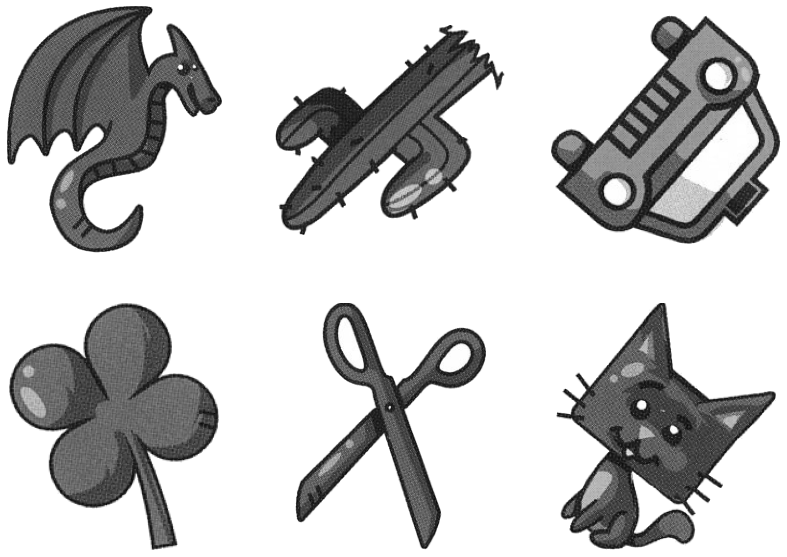

In [5]:
fig, ax_arr = plt.subplots(figsize=(14,10),nrows=2, ncols=3)

for img, ax in zip(imgs_gray, np.nditer(ax_arr, flags=["refs_ok"])):
    ax.item().imshow(img, cmap='gray')
    ax.item().set_axis_off()

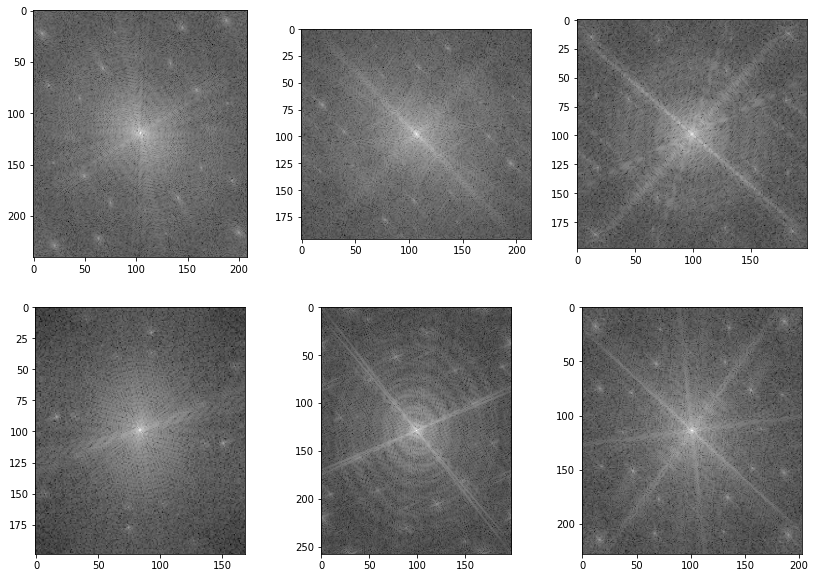

In [6]:
ffts_gray = [np.fft.fftshift(np.fft.fft2(img_gray)) for img_gray in imgs_gray]

fig, ax_arr = plt.subplots(figsize=(14,10),nrows=2, ncols=3)

for fft, ax_ref in zip(ffts_gray, np.nditer(ax_arr, flags=["refs_ok"])):
    ax = ax_ref.item()
    ax.imshow(np.log(np.abs(fft)), cmap='gray')

In [7]:
selected_fft = ffts_gray[0]

In [58]:
LAPLACIAN_KERNEL = np.array([-1, -1, -1, -1, 8, -1, -1, -1, -1], dtype=float).reshape(
    3, 3
)

def log_abs(ft_coeffs: np.ndarray):
    return np.log10(np.abs(ft_coeffs))

def compute_H_coeffs(log_abs_mat: np.ndarray):
    I_min = np.min(log_abs_mat)
    I_max = np.max(log_abs_mat)

    L = scipy.signal.convolve2d(log_abs_mat, LAPLACIAN_KERNEL, mode="same")

    L_min = np.min(L)
    L_max = np.max(L)

    return (L - L_min) * (log_abs_mat - I_min) / ((L_max - L_min) * (I_max - I_min))

In [59]:
logF = log_abs(selected_fft)
H = compute_H_coeffs(logF)

In [45]:
hist, bins = np.histogram(H, bins=20, range=(0, 1))

In [60]:
hist

array([  112,   894,  4380, 13472, 19170,  9270,  2490,   478,    80,
          14,     8,     0,     0,     0,     0,     1,     0,     0,
           0,     0])

In [65]:
def get_threshold_bin(hist: np.array) -> int:
    null_idx = np.arange(len(hist))[hist == 0]
    group_start_idx = np.hstack(([0], null_idx + 1))
    group_end_idx = np.hstack((null_idx, [hist.shape[0]]))

    group_size = group_end_idx - group_start_idx
    spread_group_idx = np.argmax(group_size)

    spread_group = hist[group_start_idx[spread_group_idx]: group_end_idx[spread_group_idx]]
    max_pop = np.max(spread_group)

    for bin_id, hist_pop in enumerate(spread_group, start=group_start_idx[spread_group_idx]):
        if (hist_pop / max_pop > 0.5):
            thres_bin_id = bin_id
            break

#     bins_id = np.digitize(H, bins) - 1
#     thres_bin = H[bins_id == thres_bin_id]
    
    return thres_bin_id

In [66]:
get_threshold_bin(hist)

3

In [67]:
thres_bin_id = get_threshold_bin(hist)
H_up, H_low = bins[thres_bin_id], bins[thres_bin_id]
H_ref = 0.5 * (H_up + H_low)

In [68]:
# thres_bin = get_threshold_bin(hist)
# H_up, H_low = np.max(thres_bin), np.min(thres_bin)
# H_ref = 0.5 * (H_up + H_low)

In [69]:
I_select = logF[H <= H_ref]
max_ref, ave_ref = np.max(I_select), np.mean(I_select)
I_ref = 0.5 * (max_ref + ave_ref)

In [70]:
Pn1_mask = ((H > H_ref) & (logF > I_ref))
Pn1_mask

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True, False,  True, ...,  True,  True,  True],
       [ True, False,  True, ..., False,  True, False],
       ...,
       [False,  True, False, ...,  True, False,  True],
       [ True,  True,  True, ...,  True, False,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [71]:
Pn1 = np.argwhere(Pn1_mask)

In [72]:
np.bincount(Pn1_mask.flatten())

array([16886, 33483])

In [73]:
np.argwhere(~Pn1)

array([[    0,     0],
       [    0,     1],
       [    1,     0],
       ...,
       [33481,     1],
       [33482,     0],
       [33482,     1]])

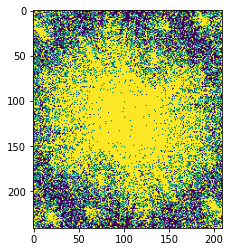

In [75]:
plt.imshow(Pn1_mask)

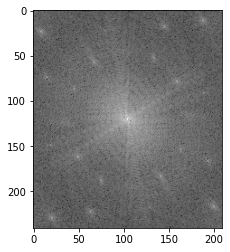

In [76]:
plt.imshow(np.log(np.abs(selected_fft)), cmap='gray')

In [146]:
def compute_eigenvalues(coords: np.ndarray, intensities: np.ndarray):
    y, x = coords.T

    Ixx = np.sum(intensities * y**2)
    Iyy = np.sum(intensities * x**2)
    Ixy = -np.sum(intensities * x * y)

    return np.linalg.eig(np.array([[Ixx, Ixy], [Ixy, Iyy]], dtype=float))


def find_central_area_mask(Pn1_mask: np.ndarray, radius: float):
    shape = Pn1_mask.shape

    Y, X = np.mgrid[0 : shape[0], 0 : shape[1]]
    Y -= (shape[0] - 1) / 2
    X -= (shape[1] - 1) / 2
    D = np.sqrt(X**2 + Y**2)

    delta = radius / 10

    center = Pn1_mask[D <= radius]

    while center.sum() / center.size > 0.85:
        radius += delta
        center = Pn1_mask[D <= radius]

    return center

In [147]:
fft_center = np.array(selected_fft.shape) / 2

In [142]:
coords = Pn1 - (np.array(selected_fft.shape) - 1) / 2
intensities = logF[Pn1[:, 0], Pn1[:, 1]]

In [143]:
eigenvals, eigenvects = compute_eigenvalues(coords, intensities)

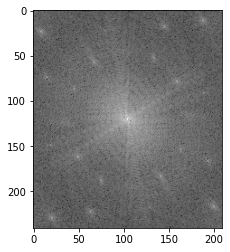

In [144]:
plt.imshow(log_abs(selected_fft), cmap='gray');

In [145]:
eigenvals

array([4.48898366e+08, 3.70461760e+08])

In [126]:
import math
radius = math.sqrt(sum(eigenvals))

TypeError: only size-1 arrays can be converted to Python scalars

In [112]:
radius

28624.46725554985

In [98]:
c0_mask = find_central_area_mask(Pn1_mask, radius)
c0 = np.argwhere(c0_mask)

UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('float64') to dtype('int64') with casting rule 'same_kind'

In [87]:
Pn2_mask = Pn1_mask & ~c0_mask
Pn2 = np.argwhere(Pn2_mask)

NameError: name 'c0_mask' is not defined

In [ ]:
eigvec_x, eigvec_y = eigenvects
theta = math.acos(np.dot(eigvec_x, eigvec_y)
                  / (np.linalg.norm(eigvec_x) * np.linalg.norm(eigvec_y))

eig_x, eig_y = eigenvals
eig_x_2 = eig_x * cos(theta) ** 2 + eig_y * sin(theta) ** 2
eig_y_2 = eig_x * eig_y / eig_x_2

In [ ]:
def loss(I0, c1, c2):
    def f(i, j):
        return (logF[i, j] \ I0(i, j) 
                - math.exp())